# Off-by-one error

This notebook is a quick analysis (with commented code!) of deep learnings ability to find off-by-one decimal errors in an income distribution. The income distribution will be simulated with a log-normal distribution.

## Libraries

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow_probability as tfp
from tensorflow import keras

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.10.1
Eager execution: True


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15632125796725569582
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5174067200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4209745482020062899
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Boilerplate (Fake Data Creation)

In [4]:
def off_by_one(mu=np.log(25), sigma=np.log(10)/3, n=int(1e5), error_rate=0.1, data=None, ordinal_error=True):
    """Create log-normal data set with off-by-one decimal error."""

    if data is None:
        true_value = np.random.lognormal(mu, sigma, n)
    else:
        true_value = data
        n = len(true_value)
    true_value = [round(i, 5) for i in true_value]
    if ordinal_error:
        error_types = [1,2,3] #-1 for left error, 1 for right error, 0 for no error.
        # tensorflow is doing a one-hot encoding, although on future iterations we would like to keep the
        # ordinal (not cardinal) nature of the error.
        error = np.random.choice(error_types, n, p=[error_rate/2, error_rate/2, 1-error_rate])
    else:
        error = np.random.binomial(1, error_rate, n)
    
    observed = np.zeros(n)
    for i in range(n):
        if error[i] == 1:
            observed[i] = true_value[i]/10
        elif error[i] == 2:
            observed[i] = true_value[i]*10
        else:
            observed[i] = true_value[i]
    data = {"error" : error, "observed" : observed, "true_value" : true_value}
    return pd.DataFrame(data=data)

## Introduction

As the amount of error increases, the observed and true value distributions become more separable. Note that with this log-normal distribution, the observed distribution becomes bimodal. However, we would expect 

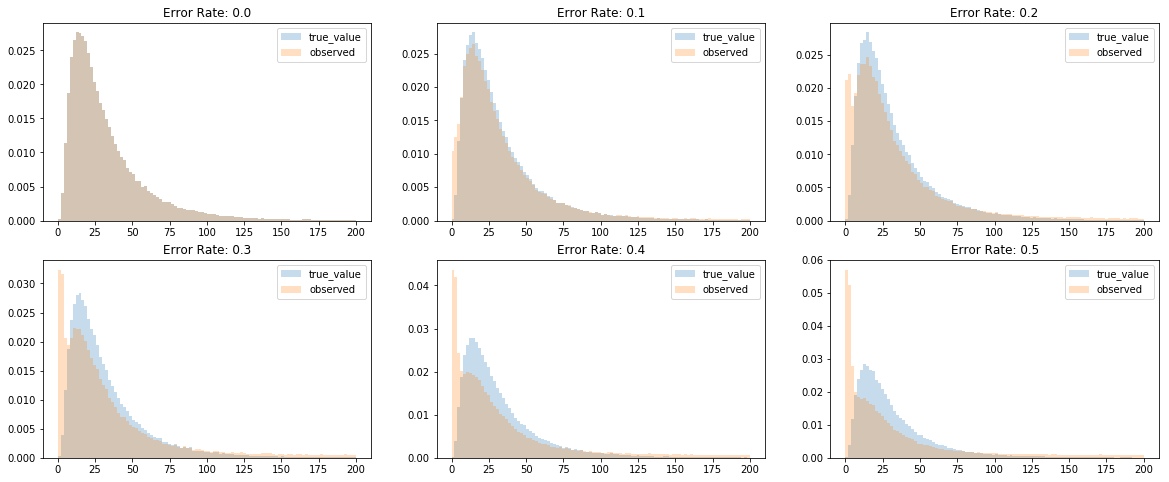

In [5]:
df = [off_by_one(mu=np.log(25), sigma=np.log(10)/3, n=int(1e5), error_rate=i) for i in np.arange(0, .6, 0.1)]

fig, axs = plt.subplots(2,3, figsize=(20,8), facecolor='w', edgecolor='k')

for ax, i in zip(axs.ravel(), range(0,6)):
        ax.hist(df[i]["true_value"], bins=100, alpha=0.25, range=[0,200], density=True)
        ax.hist(df[i]["observed"], bins=100, alpha=0.25, range=[0,200], density=True)
        ax.legend()
        ax.set_title("Error Rate: " + str(round(i*0.1, 2)))
plt.show()

## Modeling

The standard pipeline for ML is to first do an initial train/test split. This test set is also known as the holdout set as we will also split the training data set again for Cross Validation when tuning the neural net. 

In [6]:
train, test = train_test_split(df[3], test_size=0.25)
test_len = len(test)
X_train = np.array(train["observed"]).reshape(-1, 1)
y_train = np.array(train["error"])
X_test = np.array(test["observed"]).reshape(-1, 1)
y_test = np.array(test["error"])

### Deep Learning (Neural net)

Building neural nets in Tensorflow is straightforward esp. using the Keras API. The Keras API has three parts to it: building the underlying model, compiling the model, and fitting the model. In the first step, one defines the  structure of the neural net. 'model.compile' defines the optimizer to solve the neural net, loss function (or objective function), and metrics. Lastly, 'model.fit' runs the process to fit the neural net and returns the previous metrics defined in the process.

In [7]:
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
  ])
    model.compile(optimizer=tf.train.AdamOptimizer(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', keras.metrics.categorical_accuracy])
    return model

model = build_model()

In [8]:
# Print evidence of each epoch ending in readable format
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.25, verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[PrintDot()])

KeyboardInterrupt: 

In [8]:
history.history["acc"]

NameError: name 'history' is not defined

### Random Forest

In [7]:
rfc = RFC()
rfc.fit(X_train, y_train)
y_test_hat = rfc.predict(X_test)

In [8]:
accuracy_score(y_test_hat, y_test)

0.8802

### Gradient Boosting

In [9]:
gbc = GBC()
gbc.fit(X_train, y_train)
y_test_hat = gbc.predict(X_test)

In [10]:
accuracy_score(y_test_hat, y_test)

0.91804

### Bayesian Hierarchical modeling

In [37]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
}
parameter {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=0> error_rate;
}
transformed parameters {
    real observed[N];
    for (n in 1:N){
      observed[N] = true_value*error_rate
    }
}
model {
    error ~ bernoulli(error_rate)
}
"""

data = {'n': np.shape(X_train)[0],
        'x': X_train.reshape(np.shape(X_train)[0])}

sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e682b0474bb93f54ea32b851b114ebdd NOW.


In [19]:
coin_dict = fit.extract()
coin_dict.keys()

odict_keys(['p', 'lp__'])

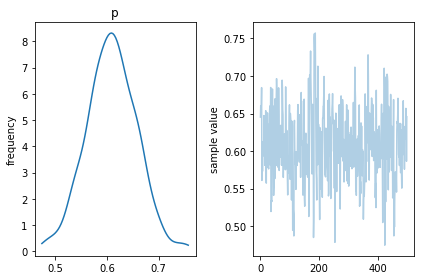

In [21]:
fit.plot('p');
plt.tight_layout()

In [13]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19a09b474d1901f191444eaf8a6b8ce2 NOW.


In [14]:
fit

Inference for Stan model: anon_model_19a09b474d1901f191444eaf8a6b8ce2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          8.2    0.17    4.9  -0.53   4.88   8.15  11.41  18.01    869    1.0
tau        6.46     0.2    5.2   0.23   2.58   5.08   9.29  19.71    709    1.0
eta[1]     0.36    0.02   0.94  -1.57  -0.22   0.37   0.98    2.2   1619    1.0
eta[2]    -0.02    0.02   0.84  -1.71  -0.57-8.6e-3   0.53   1.71   1762    1.0
eta[3]     -0.2    0.02   0.94  -1.96  -0.86   -0.2   0.45   1.69   1433    1.0
eta[4]    -0.06    0.02   0.88  -1.77  -0.65  -0.08   0.52   1.64   2026    1.0
eta[5]    -0.36    0.02   0.88  -1.99  -0.97  -0.38   0.21   1.43   1596    1.0
eta[6]    -0.24    0.02   0.85   -1.9  -0.79  -0.24    0.3   1.48   1696    1.0
eta[7]     0.35    0.02   0.91   -1.5  -0.21   0.35   0.93   2.24   1817    1.0
eta[8]     0.